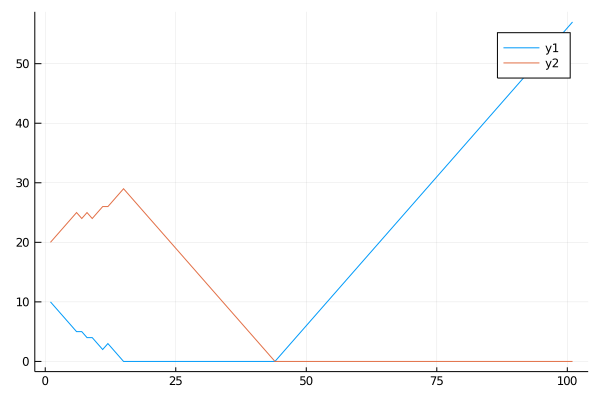

In [42]:


## Import packages
using StatsBase
using Plots

## Define Functions
function gillespie(transitions, initial, N, select_hyp="none", t0=0.0)

    """
    Implementation of the Gillespie algorithm for Lotka-Volterra model

    Args:
    transitions(dict): A dictionary with keys "prey" and "pred", and each element
        is a list containing the row of the transition matrix.
    initial(dict): A dictionary with keys 'prey' and 'predator' giving the initial
        counts for each species at the start of the sim.
    N(int): Number of desired simulation iterations.
    select_hyp(str): Default is "none", wherein a uniform prior is assigned to the
        three hypotheses.  Otherwise, "H1", "H2", or "H3" concentrates all prior
        probability on one hypothesis (useful in forward simulation).
    t0(float): initial time point.
    """

    trajectory = Dict("prey" => [initial["prey"]], "pred" => [initial["pred"]])
    times = [t0]
    ecology = initial

    theta_hypotheses = Dict(
        "H1" => Dict("spawn_prey" => 1, "prey2pred" => 1, "pred_dies" => 1),
        "H2" => Dict("spawn_prey" => 1, "prey2pred" => 1, "pred_dies" => 1),
        "H3" => Dict("spawn_prey" => 1, "prey2pred" => 1, "pred_dies" => 1))

    if select_hyp != "none"
        theta = theta_hypotheses[select_hyp]
    else
        hypoth_list = ["H1", "H2", "H3"]
        weights = [1 - 0.4, 0.2, 0.2]
        theta = theta_hypotheses[sample(hypoth_list, Weights(weights))]
    end

    t = times[1]

    for i = 1:N
        hazards = get_hazards(ecology, theta)
        transition = transitions[sample(collect(keys(hazards)), Weights(collect(values(hazards))))]
        t = t + exp(sum(values(hazards)))

        ecology["prey"] += transition[1]
        ecology["pred"] += transition[2]
        # Enforce only positive integers
        ecology["prey"] = max(0, ecology["prey"])
        ecology["pred"] = max(0, ecology["pred"])

        append!(trajectory["prey"], ecology["prey"])
        append!(trajectory["pred"], ecology["pred"])
        append!(times, t)
    end

    return Dict(
        "prey" => trajectory["prey"],
        "pred" => trajectory["pred"],
        "times" => times
        )
end

function get_hazards(ecology, theta)
    """
    Compute the hazard function given the current states.  Note that in this
        model the function depends only on state, not time, though this is not
        the case in general. "spawn_prey" represents the event of a prey being born,
        "prey2pred" represents a predator consuming a new prey and consequently spawning
        a new predator, "pred_dies" represents the death of a predator.

    args:
        ecology(dict): a dictionary containing species counts.
        theta(dict): A dictionary where keys represent events (reactions) and
            values are the location hyperparameters for rate parameter constants
            corresponding to those events.
    """

    return Dict(
        "spawn_prey" => theta["spawn_prey"] * ecology["prey"],
        "prey2pred" => theta["prey2pred"] * ecology["prey"] * ecology["pred"],
        "pred_dies" => theta["pred_dies"] * ecology["pred"]
        )
end

## Initialize Function
initial = Dict("prey" => 10, "pred" => 20)
Pre = [[1, 0], [1, 1], [0, 1]]
Post = [[2, 0], [0, 2], [0, 0]]
transition_mat = Post - Pre
transitions = Dict("spawn_prey" => transition_mat[1,],
                    "prey2pred" => transition_mat[2,],
                    "pred_dies" => transition_mat[3,])

gillespie_sim = gillespie(transitions, initial, 100, "H2", 0.0)

plot_vals = hcat(values(gillespie_sim["prey"]), values(gillespie_sim["pred"]))
plot(1:101, plot_vals)
